## SWP-Group 1. Method – Walkthrough:

The goal is to use modified and unmodified graphs with some metadata as input to S2Match, after which we can evaluate our method. <br>

In order to do this you must already have an STS-dataset:

>1. which we then would convert to a tsv-file, that would contain sentences from all the categories and their scores <br>
>2. we can then use this tsv-file to create 2 files with AMRs in them (one file for sentences A and one file for sentences B) <br>
>3. for the AMR files we create AMR2Texts alignments <br>
>4. do some graph modification or extraction of metadata from these alignments (AMRAnalysis class) <br>
>5. feed the results from 4) to S2Match <br>
>6. evaluate different approaches on original STS

### Some info about STS2016:

In [9]:
import argparse
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

In [2]:
sts = Path.cwd()/'datasets'/'sts'/'sts2016-english-with-gs-v1.0'

#sts = Path(args.input)

sts_ds_all   = list(sts.glob('STS*.*.txt'))
sts_ds_input = sorted([p for p in sts_ds_all if p.suffixes[0] == '.input'])
sts_ds_gold  = sorted([p for p in sts_ds_all if p.suffixes[0] == '.gs'])
sts_ds_input_gold = list(zip(sts_ds_input, sts_ds_gold))

sts_ds = defaultdict(list)
get_theme = lambda p: p.suffixes[1][1:]

for file_input, file_gold in sts_ds_input_gold:
    theme = get_theme(file_input)
    with open(file_gold) as gold: 
        scores = [np.nan if not line.strip() else int(line.strip()) for line in gold.readlines()]
        sts_ds['score'] += scores
        sts_ds['theme'] += [theme]*len(scores)

    with open(file_input) as inp:
        for line in inp:
            if line:
                sent1, sent2 = line.split('\t')[:2]
                sts_ds['sent1'].append(sent1); sts_ds['sent2'].append(sent2)

sts_df = pd.DataFrame(sts_ds)[['sent1', 'sent2', 'theme', 'score']]
sts_df.info()
print(f"\n{100*sum(sts_df['score'].isna())/len(sts_df):.2f}% values in 'score' are NaN!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9183 entries, 0 to 9182
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sent1   9183 non-null   object 
 1   sent2   9183 non-null   object 
 2   theme   9183 non-null   object 
 3   score   1186 non-null   float64
dtypes: float64(1), object(3)
memory usage: 287.1+ KB

87.08% values in 'score' are NaN!


In [2]:
import subprocess, shlex

def run_commands(commands, shell=False):
    for command in commands:
        print(command, '\nis being executed...','\n')
        res = subprocess.run(shlex.split(command), stdout=subprocess.PIPE, 
                             stderr=subprocess.STDOUT, text=True, shell=shell)
        for line in res.stdout.split('\n'):            
            if line:
                print(line)
        print()

In [1]:
""" Commands to run in a shell. Some of them can be run through subprocess:

{virtualenv} python3 sts2tsv.py -i datasets/sts/sts2016-english-with-gs-v1.0 -o data/STS2016_full.tsv 
{virtualenv with penman>=1.0} python3 to_amr.py -i data/STS2016_full.tsv -o data/amr/STS2016_corpus
{virtualenv with penman==0.6.2} python3 amr_pipeline.py -t AMR2Text -i data/STS2016_full.tsv -o data/amr/STS2016_corpus
"""

commands_on_my_pc = [
    'wsl python3 sts2tsv.py -i datasets/sts/sts2016-english-with-gs-v1.0 -o data/STS2016_full.tsv',
    'conda activate dlp38 && python to_amr.py -i data/STS2016_full_fix.tsv -o data/amr/STS2016_corpus',
    'wsl python3 amr_pipeline.py -t AMR2Text -o data/amr/STS2016_corpus'
]

# Run here if necessary, but the output is not live (only after command is completed)!
#run_commands(commands_on_my_pc)

Loading model C:\ProgramData\Anaconda3\envs\dlp38\Lib\site-packages\amrlib\data\model_stog\model.pt
Stog model loaded sucessfully!


>The alignment tool is not perfect and sometimes it can't align certain sentences. <br>
We could try to rewrite the code, so that these sentences are aligned, but it is pretty unfeasible, so we just throw all "bad" sentences out!

In [41]:
# 496 in b, others in a
sentences_with_errors = [98, 119, 289, 296, 392, 496, 630, 654, 660]

def reset_ids_in_aligned():
    p = Path('.')/'data'/'amr'
    paths = [p/'STS2016_corpus_a_aligned.mrp', p/'STS2016_corpus_b_aligned.mrp']
    paths_to_save = [p/'STS2016_corpus_a_aligned_e.mrp', p/'STS2016_corpus_b_aligned_e.mrp']
    edited = []

    for i, p in enumerate(paths):
        content = p.read_text().split('\n\n')
        with open(paths_to_save[i], 'a') as out:
            for a, c in enumerate(content):
                if c:
                    lines = c.split('\n')
                    id_line_spl = lines[0].split()
                    id_line_spl[-1] = str(a)
                    lines[0] = ' '.join(id_line_spl)
                    c = '\n'.join(lines) + '\n\n'
                    out.write(c)

## Concatenate relationships with the parent node

#### Imports and helper functions:

In [3]:
import penman
from penman import layout
from penman.graph import Graph
from penman.transform import reify_attributes

import re
import json
from pathlib import Path
from collections import defaultdict


def pprint(l, reified=False, **args):
    if isinstance(l, dict):
        print('Key\tValue')
        for k, v in l.items():            
            print(f'{k}\t{v}', **args)
            
    elif isinstance(l, list) or isinstance(l, tuple) or isinstance(l, set):
        for el in l:
            print(el, **args)
            
    elif isinstance(l, penman.Graph):
        if reified:
            l = penman.encode(l)
            l = reify_rename_graph_from_string(l)
        print(penman.encode(l), **args)
        
    elif isinstance(l, penman.Tree):
        if reified:
            l = penman.format(l)
            l = reify_rename_graph_from_string(l)
            print(penman.encode(l), **args)
        else:
            print(penman.format(l), **args)
        
    elif isinstance(l, str):
        if reified:
            l = reify_rename_graph_from_string(l)
            print(penman.encode(l), **args)
        else:
            print(penman.format(penman.parse(l)), **args)
            
    else:
        raise ValueError('Unknown type')
    print(**args)

#### Main class:

In [4]:
class AMRAnalysis:
    def __init__(self, amr2text_alingnment_path, keep_meta=True, 
                 extended_meta=False, concat_rel=False):
        self.amr2text_alingnment_path = amr2text_alingnment_path        
        self.keep_meta = keep_meta
        if extended_meta:
            self.keep_meta = self.extended_meta = True
        else:
            self.extended_meta = False
        self.info_dict = {}
        self.graphs_concat_rel = {}
        if concat_rel:
            self.concat_rel()
        else:
            self.extract_info()
    
    @staticmethod
    def reify_rename_graph_from_string(amr_string):
    
        g1 = reify_attributes(penman.decode(amr_string))
        t1 = layout.configure(g1)
        t1.reset_variables(fmt='MRPNode-{i}')
        g1 = layout.interpret(t1)

        return g1
    
    @staticmethod
    def alignment_labels2mrp_labels(amr_string):
        """Currently works only on reified graphs"""

        amr_graph = AMRAnalysis.reify_rename_graph_from_string(amr_string)
        epidata, triples = amr_graph.epidata, amr_graph.triples
        cur_label, popped = '0', False
        labels_dict = {cur_label:amr_graph.top}
        for triple in triples:        
            cur_node = triple[0]        
            epi = epidata[triple]
            if epi and isinstance(epi[0], penman.layout.Push):
                cur_node = epi[0].variable
                if not popped:
                    cur_label += '.0'
                labels_dict[cur_label] = cur_node
                popped = False            
            elif epi and isinstance(epi[0], penman.layout.Pop):
                pops_count = epi.count(epi[0])
                split = cur_label.split('.')
                if popped: 
                    split = split[:len(split)-pops_count] 
                else:
                    split = split[:len(split)-pops_count+1]
                split[-1] = str(int(split[-1])+1)
                cur_label = '.'.join(split)
                popped = True

        return labels_dict, amr_graph
    
    @staticmethod
    def get_alignments_dict_from_string(alignments_string, alignment_pattern, toks, labels_dict):
        """
        Somehow the alingnments string in 'new_alinged' does not contain
        all aligned nodes that are specified below ¯\_(ツ)_/¯ 
        """
        matches = re.match(alignment_pattern, alignments_string)
        if not matches:
            raise ValueError(f'Alignments string "{alignments_string}" has wrong format!\nCould not find alignments.')
        alignments = matches.group(1).split()
        alignments_dict = {}

        for alignment in alignments:
            parts = alignment.split('|')
            token_span = parts[0]
            #indices = span.split('-')
            #token_span = ' '.join(toks[int(indices[0]):int(indices[1])])
            nodes = parts[1].split('+')
            nodes = [labels_dict[node] for node in nodes]
            for node in nodes:
                alignments_dict[node] = token_span
        return alignments_dict
    
    @staticmethod
    def get_alignments_dict(nodes_block, labels_dict, alignments_with_toks=False, toks=None):
        """
        This function deals with the problem that was found while using the 
        function above
        """
        nodes_block = [spl_line for spl_line in nodes_block if len(spl_line) == 3]
        alignments_dict = {}
        for spl_line in nodes_block:
            node = spl_line[0]
            node = labels_dict[node] # '0.0.0' --> 'MRPNode2'
            token_span = spl_line[2]
            if alignments_with_toks:
                start_idx, end_idx = token_span.split('-')
                token_span = ' '.join(toks[int(start_idx):int(end_idx)])
            alignments_dict[node] = token_span
            
        return alignments_dict

    def extract_info(self, alignments_with_toks=False):    
        with open(self.amr2text_alingnment_path) as f:
            amrs = f.read().strip().split('\n\n')
            amrs = [amr.split('\n') for amr in amrs]

        alignment_pattern = re.compile(r'# ::alignments\s(.+?)\s::')

        for amr_analysis in amrs:
            amr_id = amr_analysis[0].split()[-1]

            toks = amr_analysis[2].split()[2:] # first 2 tokens are: '# ::tok'
            toks = [tok.lower() for tok in toks]

            amr_string = amr_analysis[-1]
            labels_dict, amr_graph = AMRAnalysis.alignment_labels2mrp_labels(amr_string)

            alignments_string = amr_analysis[3]
            nodes_block = [line.split()[2:] for line in amr_analysis if line.startswith('# ::node')] # first 2 tokens are: '# ::node'
            try:
                # function below works well, but the alignments string doesn't contain all alignments, 
                # so a new function has to be defined
                #alignments_dict = AMRAnalysis.get_alignments_dict_from_string(alignments_string, alignment_pattern, toks, labels_dict)
                alignments_dict = AMRAnalysis.get_alignments_dict(nodes_block, labels_dict, alignments_with_toks, toks)
                alignments_dict = defaultdict(lambda: None, alignments_dict)
            except KeyError as e:
                print(amr_id)
                pprint(amr_string, reified=True)
                pprint(labels_dict)
                raise e

            self.info_dict[amr_id] = {'amr_string':penman.encode(amr_graph), \
                                      'toks':toks, \
                                      'alignments_dict':alignments_dict, \
                                      'labels_dict':labels_dict, \
                                      'amr_graph':amr_graph}
            if self.keep_meta:
                meta = amr_analysis[:3] # save '# ::id', '# ::snt' fields
                meta = '\n'.join(meta)
                self.info_dict[amr_id]['meta'] =  meta
            if self.extended_meta:
                labels_dict_string = json.dumps(labels_dict)
                alignments_dict = json.dumps(alignments_dict)
                self.info_dict[amr_id]['meta'] +=  f'\n# ::labels_dict {labels_dict_string}\n# ::alignments_dict {alignments_dict}'
                
        return self
    
    @staticmethod
    def find_below(labels_dict):
        """
        Finds nodes below a certain node using a dictionary of the following form
        (located in 'info_dict[amr_id]['labels_dict']'):
        
        Key Value
        0 MRPNode-0
        0.0 MRPNode-1
        0.0.0 MRPNode-2
        0.0.0.0	MRPNode-3
        0.0.0.0.0 MRPNode-4
        0.0.0.0.1 MRPNode-5
        0.0.1 MRPNode-6
        0.0.1.0 MRPNode-7
        
        Returns a dict where the key is the node label (e.g 'MRPNode-2') and
        the value is a list with all nodes represented as strings below it.
        """
        nodes_below_dict = defaultdict(list)
        for key, value in labels_dict.items():
            for k, v in labels_dict.items():
                if k.startswith(key) and len(k) > len(key):
                    nodes_below_dict[value].append(v)
        return nodes_below_dict
    
    @staticmethod
    def full_span(subtree_token_spans):
        """
        Takes a list of token spans of a whole subtree
        and checks, if there are gaps. 
        
        Returns a list of indices if a token span is full, else False.
        """
        toks_indices = set()
        for token_span in subtree_token_spans:
            spl = token_span.split('-')
            i1, i2 = int(spl[0]), int(spl[1])
            indices = set(range(i1, i2))            
            toks_indices.update(indices)
        if not toks_indices:
            return None
        minimum, maximum = min(toks_indices), max(toks_indices)
        toks_indices = sorted(list(toks_indices))
        if toks_indices == list(range(minimum, maximum+1)):
            return toks_indices
        return None
    
    def concat_rel(self, rel=':mod'): 
        if not self.info_dict:
            self.extract_info()
        self.graphs_concat_rel = {}
        
        # ONLY FOR DEBUGGING CERTAIN IDS!!!
        # DELETE FOR NORMAL USE!!!
        #self.info_dict = {k:v for k, v in self.info_dict.items() if k == '3'}
        
        for amr_id in self.info_dict:
            triples_filtered = []
            g = self.info_dict[amr_id]['amr_graph']
            toks = self.info_dict[amr_id]['toks']
            alignments_dict = self.info_dict[amr_id]['alignments_dict']
            nodes_below_dict = AMRAnalysis.find_below(self.info_dict[amr_id]['labels_dict'])
            instances_dict = defaultdict(lambda: None, {node:concept for node, _, concept in g.instances()})
            reentrancies = defaultdict(lambda: None, g.reentrancies())
            
            changed_instances = {}
            nodes_to_delete = []
            epidata = {}
            
            for triple in g.triples:
                if triple[0] not in nodes_to_delete and triple[2] not in nodes_to_delete:
                    if triple[1] == rel:
                        invoked = triple[0]
                        nodes_below_invoked = nodes_below_dict[invoked]
                        nodes_below_invoked_with_invoked = nodes_below_invoked + [invoked]
                        instances_below_invoked = [instances_dict[node] for node in nodes_below_invoked]
                        
                        span = [alignments_dict[node] for node in nodes_below_invoked_with_invoked if alignments_dict[node]]
                        subtree_token_span = AMRAnalysis.full_span(span)
                        reentrancies_below_invoked = any([reentrancies[node] for node in nodes_below_invoked])
                        
                        if subtree_token_span and not reentrancies_below_invoked:
                            merged = [toks[i] for i in subtree_token_span]
                            num_nodes_in_subtree = len(nodes_below_invoked_with_invoked)
                            changed_instances[invoked] =  '_'.join(merged) + '_' + str(num_nodes_in_subtree)                           
                            nodes_to_delete += nodes_below_invoked
                            continue
                            
                    epidata[triple] = g.epidata[triple]
                    triples_filtered.append(triple)
            
            for i in range(len(triples_filtered)):
                n, r, c = triples_filtered[i]
                old_tuple = (n, r, c)
                if n in changed_instances and r == ':instance':
                    new_tuple = (n, r, changed_instances[n])
                    triples_filtered[i] = new_tuple
                    epidata = {(k if k != old_tuple else new_tuple):(v if k != old_tuple else v+[penman.layout.Pop()]) 
                               for k, v in epidata.items()}
            
            new_g = Graph(triples=triples_filtered, epidata=epidata)
            new_t = layout.configure(new_g)
            new_t.reset_variables(fmt='MRPNode-{i}')
            new_g = layout.interpret(new_t)
            self.graphs_concat_rel[amr_id] = (g, new_g)
            
            collapsed_instance_nodes = len(nodes_to_delete)
            if self.keep_meta:
                self.info_dict[amr_id]['meta'] += f'\n# ::collapsed instance nodes {collapsed_instance_nodes}'
            #else:
            #    self.info_dict[amr_id]['meta'] = f'# ::collapsed instance nodes {collapsed_instance_nodes}'
            
        return self

def save_corpus(path, amr_analysis, concatenation=False):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as f:
        if concatenation:
            if not amr_analysis.graphs_concat_rel:
                amr_analysis.concat_rel()
            for amr_id, (g, g_concat) in amr_analysis.graphs_concat_rel.items():
                meta_block = amr_analysis.info_dict[amr_id]['meta']
                print(meta_block, file=f)
                pprint(g_concat, file=f)

        else:
            for amr_id in amr_analysis.info_dict:
                meta_block = amr_analysis.info_dict[amr_id]['meta']
                print(meta_block, file=f)
                pprint(amr_analysis.info_dict[amr_id]['amr_string'], file=f)

### S2Match (SBERT-Version):

In [10]:
# Paths to a full corpus (for sentences A and B):
amr_path_a = Path('.')/'data'/'amr'/'STS2016_corpus_a_aligned.mrp'
amr_path_b = Path('.')/'data'/'amr'/'STS2016_corpus_b_aligned.mrp'

# First, we create a reified corpus without any graph transformations or extended meta:
amr_analysis0_a = AMRAnalysis(amr_path_a, concat_rel=False, extended_meta=False)
amr_analysis0_b = AMRAnalysis(amr_path_b, concat_rel=False, extended_meta=False)
save0_a = Path('.')/'analysis'/'sts'/'STS2016_corpus_a_reif.amr'
save0_b = Path('.')/'analysis'/'sts'/'STS2016_corpus_b_reif.amr'

# Second, we create a corpus without graph transformations but with extended meta:
amr_analysis1_a = AMRAnalysis(amr_path_a, concat_rel=False, extended_meta=True)
amr_analysis1_b = AMRAnalysis(amr_path_b, concat_rel=False, extended_meta=True)
save1_a = Path('.')/'analysis'/'sts'/'STS2016_corpus_a_reif_ext.amr'
save1_b = Path('.')/'analysis'/'sts'/'STS2016_corpus_b_reif_ext.amr'

# Third, we create a corpus with graph transformations (relation concatenation):
amr_analysis2_a = AMRAnalysis(amr_path_a, concat_rel=True, extended_meta=False)
amr_analysis2_b = AMRAnalysis(amr_path_b, concat_rel=True, extended_meta=False)
save2_a = Path('.')/'analysis'/'sts'/'STS2016_corpus_a_concat.amr'
save2_b = Path('.')/'analysis'/'sts'/'STS2016_corpus_b_concat.amr'

# Now we save our corpora:
save_corpus(save0_a, amr_analysis0_a, concatenation=False)
save_corpus(save0_b, amr_analysis0_b, concatenation=False)
save_corpus(save1_a, amr_analysis1_a, concatenation=False)
save_corpus(save1_b, amr_analysis1_b, concatenation=False)
save_corpus(save2_a, amr_analysis2_a, concatenation=True)
save_corpus(save2_b, amr_analysis2_b, concatenation=True)

In [6]:
# vectors are in "amr_suite/vectors/glove.6B.100d.txt"
# Run s2match script on both of them:
commands_block1 = [
    """conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev.py \
    -f analysis/sts/STS2016_corpus_a_reif.amr analysis/sts/STS2016_corpus_b_reif.amr \
    -vectors amr_suite/vectors/glove.6B.100d.txt \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sts/s2match_glove_results/STS2016_orig_results_full.txt
    """,
    
    """conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev.py \
    -f analysis/sts/STS2016_corpus_a_reif_ext.amr analysis/sts/STS2016_corpus_b_reif_ext.amr \
    -vectors amr_suite/vectors/glove.6B.100d.txt \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sts/s2match_glove_results/STS2016_concat_ver2_results_full.txt
    """,
    
    """conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev.py \
    -f analysis/sts/STS2016_corpus_a_concat.amr analysis/sts/STS2016_corpus_b_concat.amr \
    -vectors amr_suite/vectors/glove.6B.100d.txt \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sts/s2match_glove_results/STS2016_concat_ver1_results_full.txt
    """
]

commands_block2 = [
    """conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_sbert.py \
    -f analysis/sts/STS2016_corpus_a_reif.amr analysis/sts/STS2016_corpus_b_reif.amr \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sts/s2match_sbert_results/STS2016_orig_results_full.txt
    """,
    
    """conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_sbert.py \
    -f analysis/sts/STS2016_corpus_a_reif_ext.amr analysis/sts/STS2016_corpus_b_reif_ext.amr \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sts/s2match_sbert_results/STS2016_concat_ver2_results_full.txt
    """,
    
    """conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev_sbert.py \
    -f analysis/sts/STS2016_corpus_a_concat.amr analysis/sts/STS2016_corpus_b_concat.amr \
    -diffsense 0.5 -cutoff 0.5 -v --ms \
    > analysis/sts/s2match_sbert_results/STS2016_concat_ver1_results_full.txt
    """
]

run_commands(commands_block1, shell=True)
#run_commands(commands_block2, shell=True)

conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev.py     -f analysis/sts/STS2016_corpus_a_reif.amr analysis/sts/STS2016_corpus_b_reif.amr     -vectors amr_suite/vectors/glove.6B.100d.txt     -diffsense 0.5 -cutoff 0.5 -v --ms     > analysis/sts/s2match_glove_results/STS2016_orig_results_full.txt
     
is being executed... 

C:\ProgramData\Anaconda3\envs\dlp38\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)

conda activate dlp38 && python amr_suite/py3-Smatch-and-S2match/smatch/s2matchdev.py     -f analysis/sts/STS2016_corpus_a_reif_ext.amr analysis/sts/STS2016_corpus_b_reif_ext.amr     -vectors amr_suite/vectors/glove.6B.100d.txt     -diffsense 0.5 -cutoff 0.5 -v --ms     > analysis/sts/s2match_glove_results/STS2016_concat_ver2_results_full.txt
     
is being executed... 

C:\ProgramData\Anaconda3\envs\dlp38\lib\site-packages\scipy\spatial\distance.py:714: R

In [11]:
import torch
from IPython.display import display
from sentence_transformers import SentenceTransformer, util

results1 = [
    Path('.')/'analysis'/'sts'/'s2match_glove_results'/'STS2016_orig_results_full.txt',
    Path('.')/'analysis'/'sts'/'s2match_glove_results'/'STS2016_concat_ver2_results_full.txt',
    Path('.')/'analysis'/'sts'/'s2match_glove_results'/'STS2016_concat_ver1_results_full.txt'
]

results2 = [
    Path('.')/'analysis'/'sts'/'s2match_sbert_results'/'STS2016_orig_results_full.txt',
    Path('.')/'analysis'/'sts'/'s2match_sbert_results'/'STS2016_concat_ver2_results_full.txt',
    Path('.')/'analysis'/'sts'/'s2match_sbert_results'/'STS2016_concat_ver1_results_full.txt'
]

def get_smatch_scores(path, rounded=False):
    """
    Extract scores from lines which start with 'Smatch score F1' 
    """
    prefix = 'Smatch score F1 '
    scores = []
    with open(path) as f:
        for line in f:
            if line.startswith(prefix):
                if rounded:
                    score = float(round(float(line.split()[-1])))
                else:
                    score = float(line.split()[-1])
                scores.append(score)
    return scores
        
smatch_glove_concat_ver1 = get_smatch_scores(results1[-1])
smatch_glove_concat_ver2 = get_smatch_scores(results1[1])
smatch_glove_orig        = get_smatch_scores(results1[0])

smatch_sbert_concat_ver1 = get_smatch_scores(results2[-1])
smatch_sbert_concat_ver2 = get_smatch_scores(results2[1])
smatch_sbert_orig        = get_smatch_scores(results2[0])

tsv_df = pd.read_csv(Path('.')/'data'/'STS2016_full_fix.tsv', sep='\t', header=0, 
                     usecols=['sent1', 'sent2', 'sts'], 
                     names=['sent1', 'sent2', 'c3', 'sts'])

tsv_df['glove_orig'] = smatch_glove_orig
tsv_df['glove_v1']   = smatch_glove_concat_ver1
tsv_df['glove_v2']   = smatch_glove_concat_ver2

tsv_df['sbert_orig'] = smatch_sbert_orig
tsv_df['sbert_v1']   = smatch_sbert_concat_ver1
tsv_df['sbert_v2']   = smatch_sbert_concat_ver2

tsv_df['sts'] = tsv_df['sts']/5

sbert = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
embeddings1 = sbert.encode(tsv_df['sent1'], convert_to_tensor=True)
embeddings2 = sbert.encode(tsv_df['sent2'], convert_to_tensor=True)
    
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
cosine_scores = torch.diagonal(cosine_scores)

tsv_df['sbert'] = cosine_scores

display(tsv_df.head(4))
#tsv_df.info()

,sent1,sent2,sts,glove_orig,glove_v1,glove_v2,sbert_orig,sbert_v1,sbert_v2,sbert
0,Should I use IRA money to pay down my student ...,Should I cash out my IRA to pay my student loans?,1.0,0.824,0.824,0.824,0.841,0.841,0.841,0.889808
1,How do I keep an egg from cracking while being...,How do I prevent an egg cracking while hard bo...,1.0,0.736,0.736,0.736,0.735,0.735,0.735,0.890282
2,How do you remove mold from a tent?,How do I remove mildew from a tent?,1.0,0.951,0.951,0.951,0.877,0.877,0.877,0.658315
3,What could be wrong with my air conditioner?,What could be wrong with my A/C unit?,1.0,0.833,0.773,0.833,0.889,0.744,0.889,0.392749


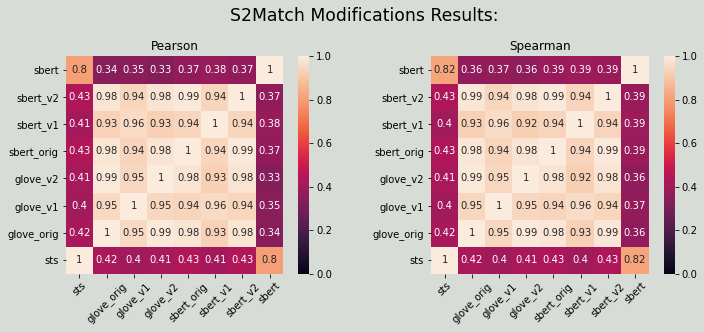

In [30]:
corr_pearson  = tsv_df.corr(method='pearson')
corr_spearman = tsv_df.corr(method='spearman')
corrs = [corr_pearson, corr_spearman]

import matplotlib.pyplot as plt
import seaborn as sns

titles = ['Pearson', 'Spearman']
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.patch.set_facecolor('xkcd:light grey')
fig.suptitle('S2Match Modifications Results:\n', fontsize='xx-large', y=1.05)

for corr_matrix, title, ax in zip(corrs, titles, axs.flat):
    #plt.figure(figsize=(5,5))
    ax = sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, vmin=0,
                     yticklabels=corr_matrix.columns, annot=True, square=True, 
                     ax=ax)
    ax.invert_yaxis()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)

fig.savefig(Path('.')/'analysis'/'sts'/'s2match_modification_results.png', 
            format='png', bbox_inches='tight')

## Experiments:

#### Basic version of the concatenation function:

In [94]:
def concat_rel(g, rel=':mod'):    
    forbidden_nodes_with_instances = {}
    triples_filtered = []
    for triple in g.triples:
        if triple[1] == rel:
            invoked = triple[0]
            forbidden_node = triple[2]
            instance = [concept for node, _, concept in g.instances() if node == forbidden_node]
            if instance:
                forbidden_nodes_with_instances[forbidden_node] = (instance[0], invoked)
            else:
                forbidden_nodes_with_instances[forbidden_node] = ('', invoked)
        else:
            triples_filtered.append(triple)       
    for forbidden_node in forbidden_nodes_with_instances:
        instance, invoked = forbidden_nodes_with_instances[forbidden_node]
        for i in range(len(triples_filtered)):
            n, r, c = triples_filtered[i]
            if n == invoked and r == ':instance' and c != 'amr-unknown':
                triples_filtered[i] = (n, r, f'{instance}_{c}')
    triples_filtered = [t for t in triples_filtered if t[0] not in forbidden_nodes_with_instances]
    epidata = {(n, r, c):g.epidata[(n, r, c.split('_')[-1])] for n, r, c in triples_filtered}
    new_g = Graph(triples=triples_filtered, epidata=epidata)    
    return new_g

new_g = concat_rel(g, ':mod')
print(penman.encode(new_g), '\n')
print(penman.encode(g))

(MRPNode-0 / possible-01
           :ARG1 (MRPNode-1 / wrong-02
                            :ARG1 (MRPNode-2 / amr-unknown)
                            :ARG2 (MRPNode-3 / air_i_conditioner))) 

(MRPNode-0 / possible-01
           :ARG1 (MRPNode-1 / wrong-02
                            :ARG1 (MRPNode-2 / amr-unknown)
                            :ARG2 (MRPNode-3 / conditioner
                                             :mod (MRPNode-4 / i)
                                             :mod (MRPNode-5 / air))))


#### Similarity Measures: SBert models vs GloVe 6B.100d

In [1]:
import numpy as np
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer, util

In [2]:
def cos(a,b):
    #cosine similarity
    dist = cosine(a,b)
    sim = 1 - min(1,dist)
    return sim

def load_glove(fp):
    dic={}
    if not fp:
        return dic
    with open(fp,"r") as f:
        for line in f:
            ls = line.split()
            word = ls[0]
            vec = np.array([float(x) for x in ls[1:]])
            dic[word] = vec
    return dic

def vecs_of_sents(m, sents):
    s_vs = np.asarray([np.sum([m[word] for word in sent.split()], axis=0)/len(sent.split()) for sent in sents])
    return s_vs

def print_scores(s1, s2, cosine_scores):
    max_s1 = max([len(s) for s in s1])
    max_s2 = max([len(s) for s in s2])
    
    for i in range(cosine_scores.shape[0]):
        for j in range(cosine_scores.shape[1]):
            print(f'{s1[i]:{max_s1}}\t{s2[j]:{max_s2}}\tScore: {cosine_scores[i, j]:.4f}')
            
def sbert_sim(model, s1, s2):
    embeddings1 = model.encode(s1, convert_to_tensor=True)
    embeddings2 = model.encode(s2, convert_to_tensor=True)
    
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    
    print_scores(s1, s2, cosine_scores)
            
def glove_sim(model, s1, s2):
    embeddings1 = vecs_of_sents(model, s1)
    embeddings2 = vecs_of_sents(model, s2)
    
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    
    print_scores(s1, s2, cosine_scores)


sbert1 = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
sbert2 = SentenceTransformer('paraphrase-distilroberta-base-v1')
glove = load_glove('amr_suite/vectors/glove.6B.100d.txt')

In [3]:
#s1 = ['french fries']
#s2 = ['chip', 'chips']
s1 = ['We eat french fries.', 'We eat french fries .', 'We eat french fries']
s2 = ['We eat chips.', 'We eat chips .', 'We eat chips']

#s1_glove = ['how do i pump up water pressure in my shower ?']
#s2_glove = ['how can i boost the water pressure in my shower ?']

print('"paraphrase-distilroberta-base-v1":')
sbert_sim(sbert2, s1, s2)
print('\n')
print('"distilbert-base-nli-stsb-mean-tokens":')
sbert_sim(sbert1, s1, s2)

"""
print('\n')
print('"GloVe average":')
glove_sim(glove, s1, s2)
"""

"paraphrase-distilroberta-base-v1":
We eat french fries. 	We eat chips. 	Score: 0.5431
We eat french fries. 	We eat chips .	Score: 0.3898
We eat french fries. 	We eat chips  	Score: 0.5067
We eat french fries .	We eat chips. 	Score: 0.3834
We eat french fries .	We eat chips .	Score: 0.4945
We eat french fries .	We eat chips  	Score: 0.3968
We eat french fries  	We eat chips. 	Score: 0.5006
We eat french fries  	We eat chips .	Score: 0.3953
We eat french fries  	We eat chips  	Score: 0.5043


"distilbert-base-nli-stsb-mean-tokens":
We eat french fries. 	We eat chips. 	Score: 0.2958
We eat french fries. 	We eat chips .	Score: 0.2958
We eat french fries. 	We eat chips  	Score: 0.3143
We eat french fries .	We eat chips. 	Score: 0.2958
We eat french fries .	We eat chips .	Score: 0.2958
We eat french fries .	We eat chips  	Score: 0.3143
We eat french fries  	We eat chips. 	Score: 0.2940
We eat french fries  	We eat chips .	Score: 0.2940
We eat french fries  	We eat chips  	Score: 0.3407


'\nprint(\'\n\')\nprint(\'"GloVe average":\')\nglove_sim(glove, s1, s2)\n'